<a href="https://colab.research.google.com/github/jdberkson/OPTI-556-Computational-Imaging/blob/main/Homework4_JoelB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4 OPTI 556

### Joel Berkson 11/2/2021

In [6]:
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib import animation, rc
from skimage import io
from skimage import transform
from skimage import filters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
from google.colab import files
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist

#### Holography

Angular Spectrum Function

In [4]:
def g(f,d,lam):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
  # Pad input field with zeros so that output sampling is same
  zPad=np.int(np.abs(d*lam))
  inF=np.zeros(np.add(f.shape,[zPad,zPad])).astype('complex128')
  inF[np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2),np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2)]=f
  
  urange=np.linspace(-lam/2,lam/2,inF.shape[0])
  u,v = np.meshgrid(urange,urange)
  g=np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *(d/lam)*np.sqrt( 1 - u**2 - v**2))))
  return g

First I just wanted to try propagating a circular fringe object using both in-line and off-axis holography.

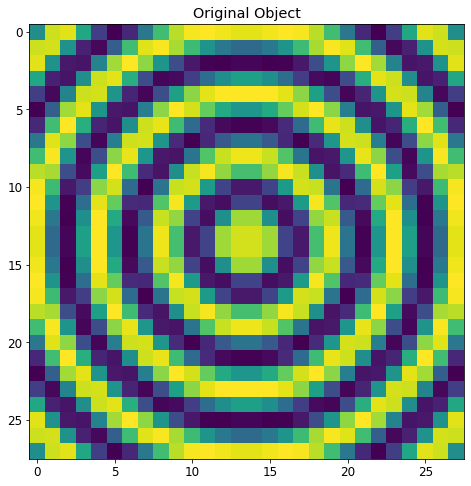

In [5]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 12})
X = np.linspace(-1,1,28)
Y = X
X, Y = np.meshgrid(X,Y)
R = np.sqrt(X**2+Y**2)
Fringe = np.sin((R)*20)
plt.imshow(Fringe)
plt.title('Original Object')
r=1
N=512
theta=np.pi/50
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths
f=np.zeros([N,N])
# insert the mnist image in the center of the field
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=Fringe
q=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo_offaxis=np.abs(q +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2
holo_inline=np.abs(q +r)**2


659344
1236544


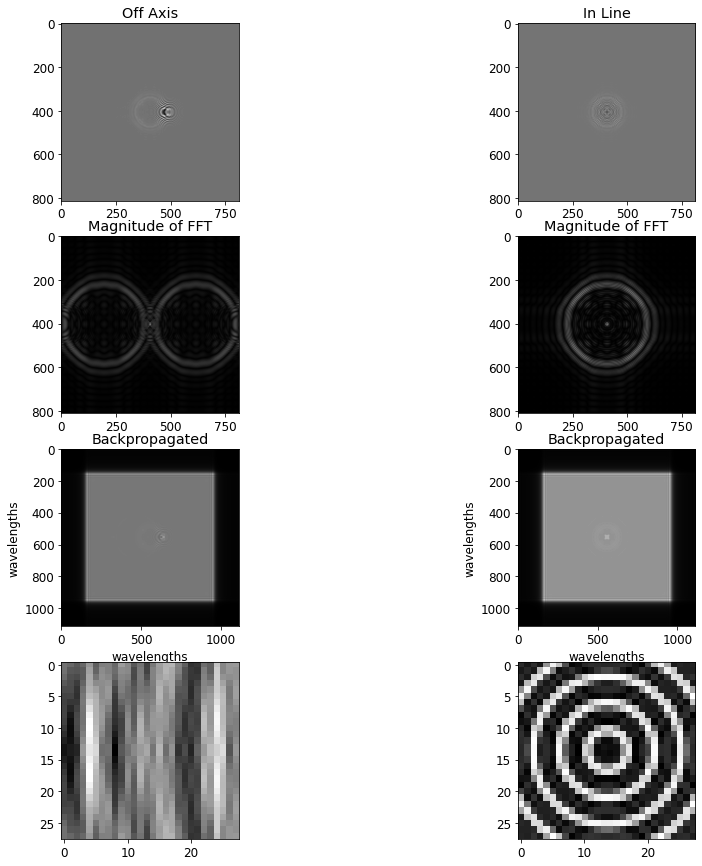

In [10]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(4,2,1)
plt.imshow(holo_offaxis-r**2, cmap='gray', aspect='equal')
plt.title('Off Axis')
plt.subplot(4,2,2)
plt.title('In Line')
plt.imshow(holo_inline-r**2, cmap='gray', aspect='equal')
plt.subplot(4,2,3)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(holo_offaxis-r**2))),cmap='gray', aspect='equal')
plt.title('Magnitude of FFT')
plt.subplot(4,2,4)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(holo_inline-r**2))),cmap='gray', aspect='equal')
plt.title('Magnitude of FFT')
plt.subplot(4,2,5)
plt.imshow(np.abs(g(holo_offaxis,-d,lam)),cmap='gray', aspect='equal')
plt.title('Backpropagated')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(4,2,6)
plt.imshow(np.abs(g(holo_inline,-d,lam)),cmap='gray', aspect='equal')
plt.title('Backpropagated')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(4,2,7)
print(np.size(holo_offaxis))
plt.imshow(np.abs(g(holo_offaxis,-d,lam)[542:570,542:570]),cmap='gray', aspect='equal')
plt.subplot(4,2,8)
print(np.size(np.abs(g(holo_inline,-d,lam))))
plt.imshow(np.abs(g(holo_inline,-d,lam)[542:570,542:570]),cmap='gray', aspect='equal')

Clearly the off-axis version does not work well for this particular pattern.

I also tried the random input field hologram reconstruction, and it worked fairly well, with some phase error,but the overall structure was recovered.

(-0.5, 27.5, 27.5, -0.5)

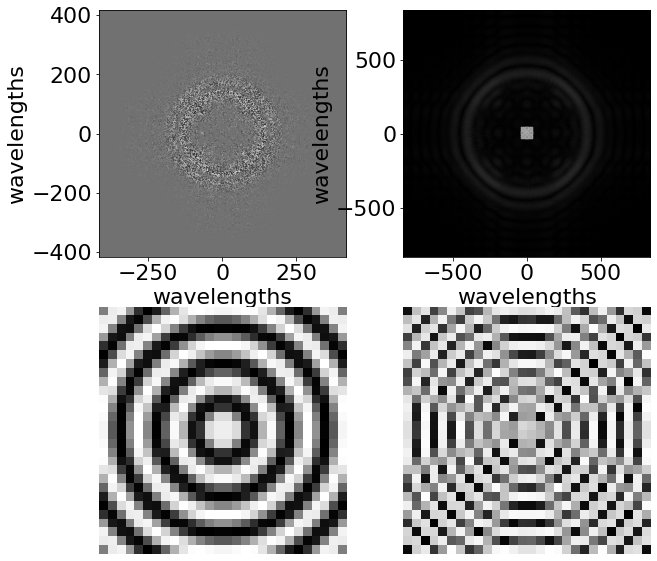

In [11]:
# diffracted field
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 22})
r=1
N=512
theta=np.pi/50
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths
f=np.zeros([N,N])
# insert the mnist image in the center of the field
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=Fringe
q=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
reference=np.exp(np.pi*1j*np.random.randint(2,size=q.shape))
holo=np.abs(q +reference)**2
plt.subplot(2,2,1)
hS=holo.shape[0]/4
plt.imshow(holo[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4], cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(2,2,2)
pip=g(reference*(holo-1),-d,lam)
xrange=d/lam
hS=pip.shape[0]/4
plt.imshow(np.abs(pip)[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(2,2,3)
plt.imshow(Fringe,cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.abs(pip[542:570,542:570]),cmap='gray', aspect='equal')
plt.axis('off')

Overall this is much better, but there is still some phase issues which almost look like aliasing in the reconstructed image. Next is the Gabor Hologram, which should do an even better job.

Text(0, 0.5, 'wavelengths')

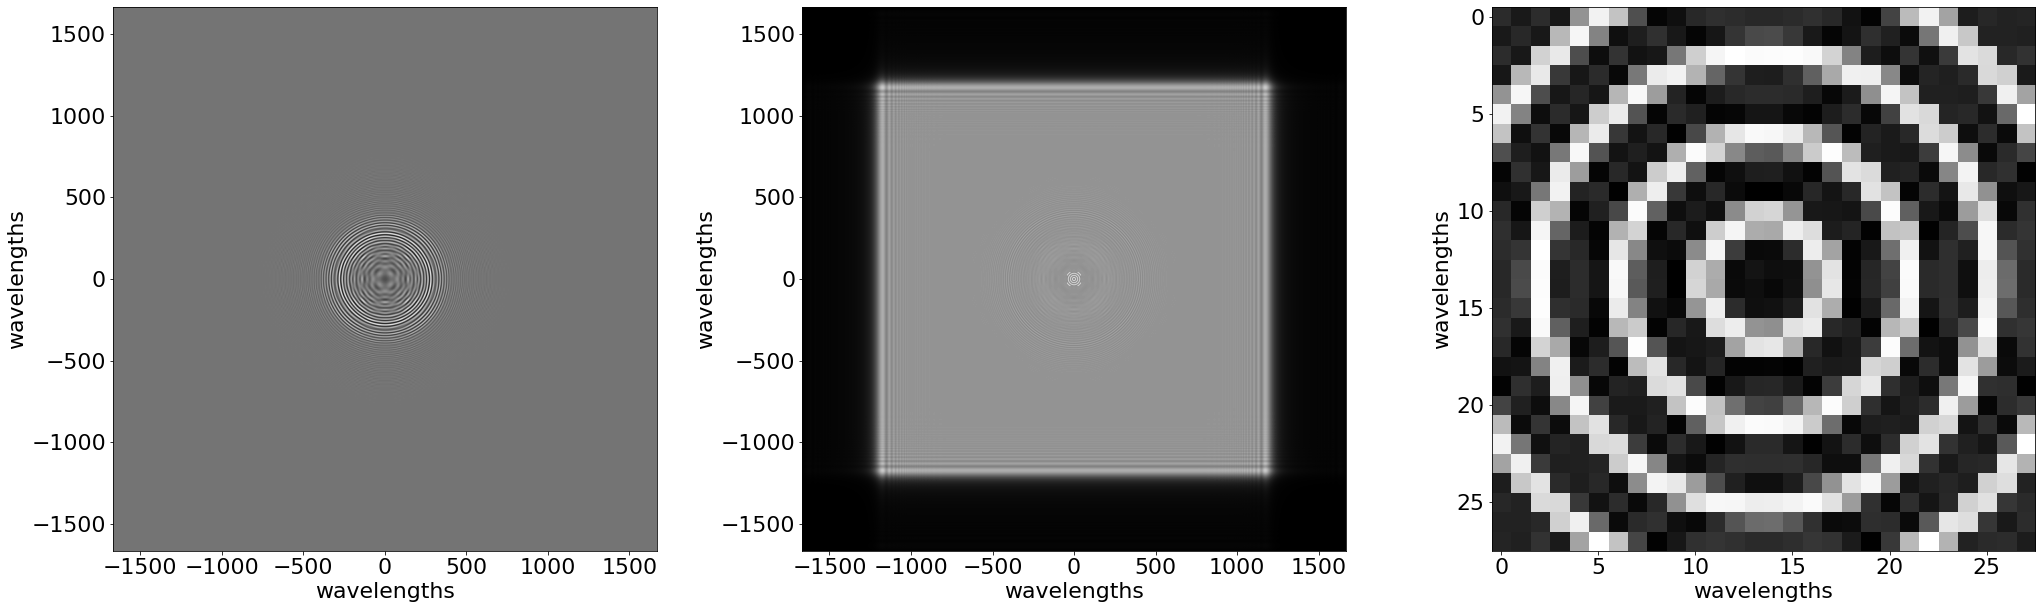

In [ ]:

# diffracted field
plt.rcParams['figure.figsize'] = [35, 10]
plt.rcParams.update({'font.size': 22})
r=1
N=512
theta=0
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths
f=np.zeros([N,N])
# insert the mnist image in the center of the field
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=Fringe
q=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo=np.abs(q +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2
plt.subplot(1,3,1)
plt.imshow(holo-r**2,extent=[-xrange,xrange,-xrange,xrange], cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(1,3,2)
plt.imshow(np.abs(g(holo,-d,lam)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(1,3,3)
plt.imshow(np.abs(g(holo,-d,lam)[542:570,542:570]),cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

Clearly the reconstruction is much better, but has some speckle due to the introduction of random phase(See speckle below)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


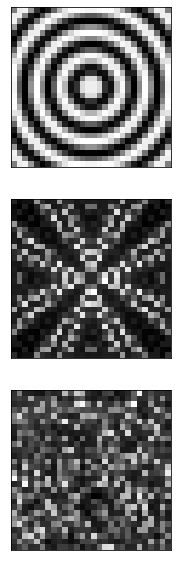

In [ ]:

# diffracted field
plt.figure(figsize=(20, 10))
r=1
N=512
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths

ax = plt.subplot(3, 1, 1)
plt.imshow(Fringe.reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(3, 1, 2)
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*Fringe)
q=g(f,d,lam)
holo=np.abs(q +r)**2
plt.imshow(np.abs(g(holo,-d,lam))[542:570,542:570])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(3, 1, 3)
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*Fringe
q=g(f,d,lam)
holo=np.abs(q +r)**2
plt.imshow(np.abs(g(holo,-d,lam)[542:570,542:570]))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Now to try a neural estimator for multiplane objects. I am thinking I will do it like this:
There will be 4 possible planes for the object to exist in each sepated by d=100(to save computing time). This will make it so that the training data output is 28x28x4, and the input data will simply be the sum of each hologram (in reality, the field scattered from the first plane would hit the next plane, and then the next etc. but this sounds too complicated for now)

I spent a pretty long time getting this to work. I am pretty sure I formatted the input/output data correctly (verified by looking at each set manually), but I just never could get a network structure to converse to a loss better than 0.06 (it always just got stuck and oscillated around that value). I tried lots of different networks, but ultimately I am lost there. Happy to retry this if you have any suggestions, I just dont have the time to try any more configurations.


In [13]:
def gp(f,d,lam):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
  # Pad input field with zeros so that output sampling is same
  zPad=np.int(np.abs(d*lam))
  inF=np.zeros(np.add(f.shape,[zPad,zPad])).astype('complex128')
  inF[np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2),np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2)]=f
  
  urange=np.linspace(-lam/2,lam/2,inF.shape[0])
  u,v = np.meshgrid(urange,urange)
  g=np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *(d/lam)*np.sqrt( 1 - u**2 - v**2))))
  return g

In [21]:
# load the mnist dataset of characters
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0
print(np.shape(x_train))
x_test = x_test[0:4000]
y_test = y_test[0:4000]
x_train = x_train[0:4000]
y_train = y_train[0:4000]
N=512
f1=np.zeros([N,N]).astype('complex128')
f2=np.zeros([N,N]).astype('complex128')
f3=np.zeros([N,N]).astype('complex128')
f4=np.zeros([N,N]).astype('complex128')
x_trainstacked = np.zeros([len(x_test)//4,4,28,28])
x_teststacked = np.zeros([len(x_test)//4,4,28,28])
holo = np.zeros([N,N])
#
# holographic recordin parameters
r=1
N=512
lam=.3 # ratio of wavelength to the sampling period
d=[700,800,900,1000]
g_test=np.zeros((len(x_test)//4,28,28,8)).astype('complex128')
g_train=np.zeros((len(x_train)//4,28,28,8)).astype('complex128')

# generation of test inputs
for pop in range(0,np.shape(x_test)[0],4):
  randref = np.random.random((28,28))
  f1[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*randref)*x_train[pop,:,:]
  f2[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*randref)*x_train[pop+1,:,:]
  f3[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*randref)*x_train[pop+2,:,:]
  f4[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*randref)*x_train[pop+3,:,:]
  q1=gp(f1,d[0],lam)
  q2=gp(f2,d[1],lam)[15:-15,15:-15]
  q3=gp(f3,d[2],lam)[30:-30,30:-30]
  q4=gp(f4,d[3],lam)[45:-45,45:-45]
  holo=np.abs(q1+q2+q3+q4 +r)**2
 
  
  iq1=gp(holo,-d[0],lam)[452:480,452:480]
  iq1=iq1/np.max(np.abs(iq1))

  iq2=gp(holo,-d[1],lam)[452+15:480+15,452+15:480+15]
  iq2=iq2/np.max(np.abs(iq2))

  iq3=gp(holo,-d[2],lam)[452+30:480+30,452+30:480+30]
  iq3=iq3/np.max(np.abs(iq3))

  iq4=gp(holo,-d[3],lam)[452+45:480+45,452+45:480+45]
  iq4=iq4/np.max(np.abs(iq4))
  


  g_train[pop//4,:,:,0]=(1+np.real(iq1))/2
  g_train[pop//4,:,:,1]=(1+np.imag(iq1))/2
  
  g_train[pop//4,:,:,2]=(1+np.real(iq2))/2
  g_train[pop//4,:,:,3]=(1+np.imag(iq2))/2
  
  g_train[pop//4,:,:,4]=(1+np.real(iq3))/2
  g_train[pop//4,:,:,5]=(1+np.imag(iq3))/2
  
  g_train[pop//4,:,:,6]=(1+np.real(iq4))/2
  g_train[pop//4,:,:,7]=(1+np.imag(iq4))/2
  x_trainstacked[pop//4,:,:,:] = x_train[pop:pop+4,:,:]
# generation of training inputs
for pop in range(0,np.shape(x_test)[0],4):
  randref = np.random.random((28,28))
  f1[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*randref)*x_test[pop,:,:]
  f2[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*randref)*x_test[pop+1,:,:]
  f3[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*randref)*x_test[pop+2,:,:]
  f4[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*randref)*x_test[pop+3,:,:]
  q1=gp(f1,d[0],lam)
  q2=gp(f2,d[1],lam)[15:-15,15:-15]
  q3=gp(f3,d[2],lam)[30:-30,30:-30]
  q4=gp(f4,d[3],lam)[45:-45,45:-45]

  holo=np.abs(q1+q2+q3+q4 +r)**2
 
  
  iq1=gp(holo,-d[0],lam)[452:480,452:480]
  iq1=iq1/np.max(np.abs(iq1))

  iq2=gp(holo,-d[1],lam)[452+15:480+15,452+15:480+15]
  iq2=iq2/np.max(np.abs(iq2))

  iq3=gp(holo,-d[2],lam)[452+30:480+30,452+30:480+30]
  iq3=iq3/np.max(np.abs(iq3))

  iq4=gp(holo,-d[3],lam)[452+45:480+45,452+45:480+45]
  iq4=iq4/np.max(np.abs(iq4))
  


  g_test[pop//4,:,:,0]=(1+np.real(iq1))/2
  g_test[pop//4,:,:,1]=(1+np.imag(iq1))/2
  
  g_test[pop//4,:,:,2]=(1+np.real(iq2))/2
  g_test[pop//4,:,:,3]=(1+np.imag(iq2))/2
  
  g_test[pop//4,:,:,4]=(1+np.real(iq3))/2
  g_test[pop//4,:,:,5]=(1+np.imag(iq3))/2
  
  g_test[pop//4,:,:,6]=(1+np.real(iq4))/2
  g_test[pop//4,:,:,7]=(1+np.imag(iq4))/2
  x_teststacked[pop//4,:,:,:] = x_test[pop:pop+4,:,:]

x_train = np.transpose(x_trainstacked,(0,2,3,1))
x_test = np.transpose(x_teststacked,(0,2,3,1))

(60000, 28, 28)


In [24]:
inputs=keras.Input(shape=(28,28,8))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(64, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)

# Decoder

x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(4, (3, 3), activation="linear", padding="same")(x)


gaborEstimator = keras.Model(inputs, x)
gaborEstimator.compile(optimizer='adam', loss='mean_squared_error')
gaborEstimator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 8)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        6432      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 32)        1846

In [25]:

gaborEstimator.fit(
    x=g_train,
    y=x_train,
    epochs=20,
    batch_size=64,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/20
2/2 [==============================] - 1s 531ms/step - loss: 0.1040 - val_loss: 0.0932
Epoch 2/20
2/2 [==============================] - 1s 339ms/step - loss: 0.0969 - val_loss: 0.0889
Epoch 3/20
2/2 [==============================] - 1s 338ms/step - loss: 0.0937 - val_loss: 0.0865
Epoch 4/20
2/2 [==============================] - 1s 341ms/step - loss: 0.0909 - val_loss: 0.0849
Epoch 5/20
2/2 [==============================] - 1s 340ms/step - loss: 0.0881 - val_loss: 0.0814
Epoch 6/20
2/2 [==============================] - 1s 357ms/step - loss: 0.0851 - val_loss: 0.0789
Epoch 7/20
2/2 [==============================] - 1s 333ms/step - loss: 0.0821 - val_loss: 0.0760
Epoch 8/20
2/2 [==============================] - 1s 338ms/step - loss: 0.0791 - val_loss: 0.0732
Epoch 9/20
2/2 [==============================] - 1s 328ms/step - loss: 0.0761 - val_loss: 0.0708
Epoch 10/20
2/2 [==============================] - 1s 329ms/step - loss: 0.0741 - val_loss: 0.0687
Epoch 11/20
2/2 [==

(1, 28, 28, 4)


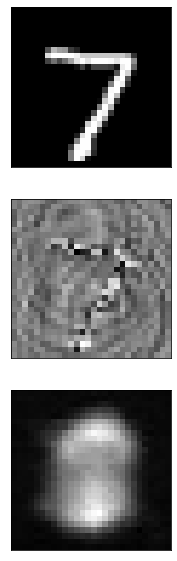

In [23]:
print(np.shape(gaborEstimator.predict(g_test[0:1,:,:,0:8])))
n = 5

ax = plt.subplot(3, 1, 1)
plt.imshow(x_test[0,:,:,0])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.real(g_test[0,:,:,0]))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(3, 1, 3)
plt.imshow(gaborEstimator.predict(g_test[0:1,:,:,0:8])[0,:,:,0])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Part 2: Fourier Ptychography and Phase Retrieval

First I will try the hybrid input/output phase retrieval method on the same ring pattern from part 1.
The basic idea here is to fft the backprojected image (which will have the wrong phase), then replace the maginitude of the fft with the measured magnitude, then inverse fft, replace the magnitude with the measured magnitude again, and repeat. The phase over time will start to converge to the correct phase.

(-0.5, 255.5, 255.5, -0.5)

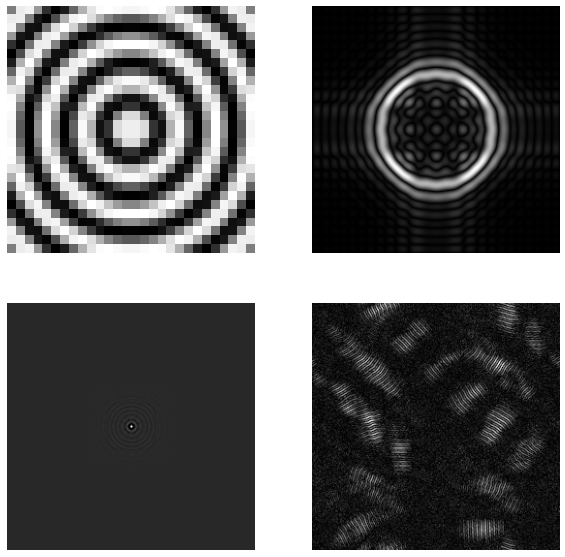

In [42]:
# number of iterations and value of beta
iterations=400
beta=0.8
# input image field
X = np.linspace(-1,1,28)
Y = X
X, Y = np.meshgrid(X,Y)
R = np.sqrt(X**2+Y**2)
Fringe = np.sin((R)*20)
im=Fringe
f=np.pad(im,np.int((256-im.shape[0])/2))
hatf=np.abs(np.fft.fft2(f))
#
# initalize phase of hat f
#
hatPhi=2*np.pi*np.random.random(hatf.shape)
fest=np.zeros(np.shape(f))
for pop in range(iterations):
  tf=np.real(np.fft.ifft2(hatf*np.exp(1j*hatPhi)))
  tfL=np.ndarray.flatten(tf)
  pf=np.ndarray.flatten(fest)
  for pip in range(len(tfL)):
    if tfL[pip]<0:
      pf[pip]=pf[pip]-beta*tfL[pip]
    else:
      pf[pip]=tfL[pip]
  fest=np.reshape(pf,np.shape(f))
  hatPhi=np.angle(np.fft.fft2(fest))
plt.subplot(2,2,1)
plt.imshow(im, cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.fft.fftshift(hatf), cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.real(np.fft.fftshift(np.fft.ifft2(hatf))), cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(fest, cmap='gray', aspect='equal')
plt.axis('off')


Well, Clearly the fringe pattern is too much to handle for this particular algorithm. Let's try something simpler:

(-0.5, 255.5, 255.5, -0.5)

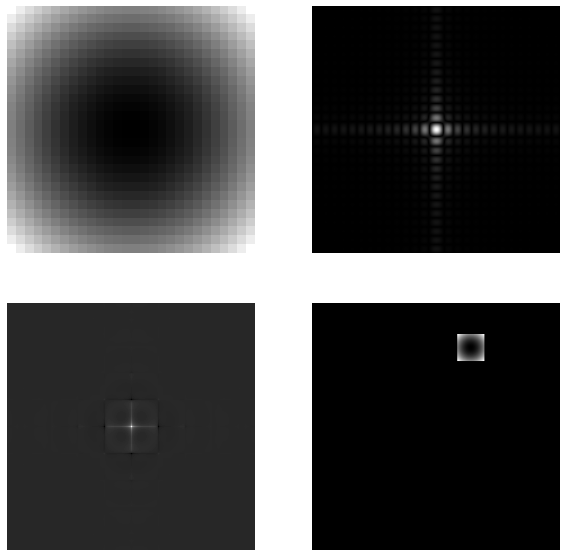

In [44]:
# number of iterations and value of beta
iterations=200
beta=1
X = np.linspace(-1,1,28)
Y = X
X, Y = np.meshgrid(X,Y)
R = np.sqrt(X**2+Y**2)
Fringe = R**2
# input image field
im=Fringe
f=np.pad(im,np.int((256-im.shape[0])/2))
hatf=np.abs(np.fft.fft2(f))
#
# initalize phase of hat f
#
hatPhi=2*np.pi*np.random.random(hatf.shape)
fest=np.zeros(np.shape(f))
for pop in range(iterations):
  tf=np.real(np.fft.ifft2(hatf*np.exp(1j*hatPhi)))
  tfL=np.ndarray.flatten(tf)
  pf=np.ndarray.flatten(fest)
  for pip in range(len(tfL)):
    if tfL[pip]<0:
      pf[pip]=pf[pip]-beta*tfL[pip]
    else:
      pf[pip]=tfL[pip]
  fest=np.reshape(pf,np.shape(f))
  hatPhi=np.angle(np.fft.fft2(fest))
plt.subplot(2,2,1)
plt.imshow(im, cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.fft.fftshift(hatf), cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.real(np.fft.fftshift(np.fft.ifft2(hatf))), cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(fest, cmap='gray', aspect='equal')
plt.axis('off')

It has a much easier job estimating this simply Quadratic phase mask (so, a lens haha). Lets add a linear term in X now

(-0.5, 255.5, 255.5, -0.5)

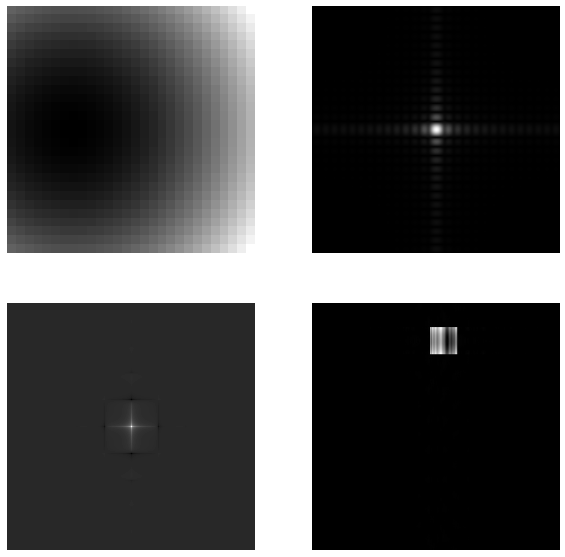

In [51]:
# number of iterations and value of beta
iterations=300
beta=.8
X = np.linspace(-1,1,28)
Y = X
X, Y = np.meshgrid(X,Y)
R = np.sqrt(X**2+Y**2)
Fringe = R**2+X+1
# input image field
im=Fringe
f=np.pad(im,np.int((256-im.shape[0])/2))
hatf=np.abs(np.fft.fft2(f))
#
# initalize phase of hat f
#
hatPhi=2*np.pi*np.random.random(hatf.shape)
fest=np.zeros(np.shape(f))
for pop in range(iterations):
  tf=np.real(np.fft.ifft2(hatf*np.exp(1j*hatPhi)))
  tfL=np.ndarray.flatten(tf)
  pf=np.ndarray.flatten(fest)
  for pip in range(len(tfL)):
    if tfL[pip]<0:
      pf[pip]=pf[pip]-beta*tfL[pip]
    else:
      pf[pip]=tfL[pip]
  fest=np.reshape(pf,np.shape(f))
  hatPhi=np.angle(np.fft.fft2(fest))
plt.subplot(2,2,1)
plt.imshow(im, cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.fft.fftshift(hatf), cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.real(np.fft.fftshift(np.fft.ifft2(hatf))), cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(fest, cmap='gray', aspect='equal')
plt.axis('off')

This one is interesting. It gets the general idea of what the shape should look like, but it has some underlying higher frequency error. Not sure what thats from. More iterations doesn't really help

Now to try some FP stuff. Below are all the necessary functions.

In [2]:
def get_measurement(im,photons,is_noisy,is_energy_constraint):
    X = np.zeros([num_frame,measure_dim,measure_dim])
    x = np.pad(np.fft.fftshift(np.fft.fft2(im.astype('complex128')))/input_dim,((pad,pad),(pad,pad)))
    if is_energy_constraint == True:
        x = x / np.sqrt(pattern)
    for i in range(num_frame):
        X[i,:,:] = np.abs(np.fft.ifft2(x[cam_locations[i,0]:cam_locations[i,0]+dim_measure[i],
                                        cam_locations[i,1]:cam_locations[i,1]+dim_measure[i]]* get_pupil(dim_measure[i]))) *np.sqrt(photons) * dim_measure[i]
    if is_noisy:
        X = np.sqrt(np.random.poisson(np.power(X,2)))
    return X/np.sqrt(photons)
def reconstruction(measure,is_energy_constraint):
    ## AP
    initial_image = cv2.resize(measure[45,:,:],(512,512))
    xest = np.pad(np.fft.fftshift(np.fft.fft2(initial_image.astype('complex128')))/input_dim,((pad,pad),(pad,pad)))
    order = list(range(num_frame))
    for iter_ in range(100):
        xest[0:pad,:] = 0
        xest[pad+512:pad*2 + 512,:] = 0
        xest[:,0:pad] = 0
        xest[:pad+512:pad*2 + 512] = 0
        random.shuffle(order)
        for im_idx in order:
            im = np.fft.ifft2(xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
                                   cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]]* get_pupil(dim_measure[im_idx]))
            im = measure[im_idx,:,:].astype('complex128') * np.exp(1j * np.angle(im))
            xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
                 cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]] = xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
                                                                                             cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]] * (1-get_pupil(dim_measure[im_idx])) + np.fft.fft2(im) / dim_measure[im_idx] * get_pupil(dim_measure[im_idx])
    if is_energy_constraint == True:
        estimate = np.fft.ifft2(np.fft.ifftshift(xest[pad:pad + input_dim,pad:pad + input_dim] * np.sqrt(pattern[pad:pad + input_dim,pad:pad + input_dim]))) * input_dim
    else:
        estimate = np.fft.ifft2(np.fft.ifftshift(xest[pad:pad + input_dim,pad:pad + input_dim])) * input_dim
    return estimate
def mse_loss(xest,y):
    error = abs(xest)**2 + abs(y)**2-2*np.abs(np.conjugate(xest)*y)
    return np.mean(error)
## PUPIL
def get_pupil(apD):
    # apD: diameter of the aperture
    # returns an array apD by apD array enclosing an circular aperture of radius apD/a
    r = apD/2
    y,x = np.ogrid[-r+0.5: r:1, -r+0.5: r]
    disk = x**2+y**2 <= r**2 
    disk = disk.astype(float)
    return disk

Lets go back to trying the ring pattern again to see if FP can do better.

In [11]:

input_dim = 512     # image dimension (512,512)
pad = 8 + 25       # Adding padding to the fourier space
measure_dim = 128     # diameter of the aperture
spacing = int(np.round(128 * (1-0.61)))   # spacing between apertures, ensure 61% overlap
mesh = np.arange(0,input_dim + 2  * pad - measure_dim + 1,spacing)
xlocations,ylocations = np.meshgrid(mesh,mesh);
xlocations = xlocations.astype(int).flatten()
ylocations = ylocations.astype(int).flatten()
num_frame = len(mesh)**2
dim_measure = np.ones([num_frame],'int') * measure_dim
cam_locations = np.concatenate([xlocations.reshape([-1,1]),ylocations.reshape([-1,1])],1)
  
## pattern
pattern = np.zeros([input_dim + 2  * pad,input_dim + 2  * pad])
pattern[pad:input_dim + pad,pad:input_dim + pad] = 2
for i in range(len(dim_measure)):
    pattern[cam_locations[i,0]:cam_locations[i,0]+dim_measure[i],
            cam_locations[i,1]:cam_locations[i,1]+dim_measure[i]] += get_pupil(dim_measure[i])


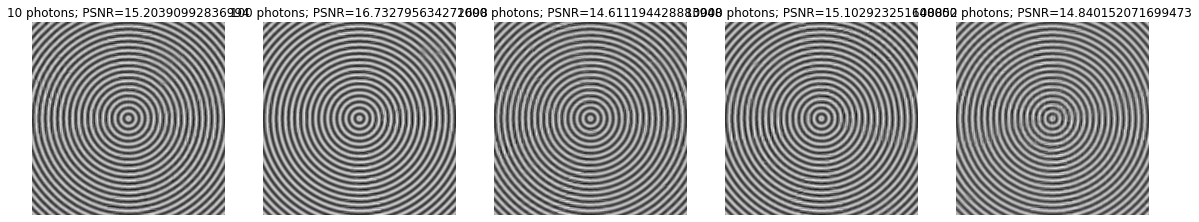

In [15]:
# input image field
X = np.linspace(-1,1,512)
Y = X
X, Y = np.meshgrid(X,Y)
R = np.sqrt(X**2+Y**2)
Fringe = np.sin((R)*100)
im=Fringe
# measurement
plt.figure(figsize= (20,5))

for pip in range(5):
  measurement = get_measurement(im,photons = 10**(pip+1),is_noisy = True ,is_energy_constraint = False)

# Check energy
#print("Energy before / after:",np.sum(im**2),np.sum(measurement**2))

# reconstruction
  estimate = reconstruction(measurement,is_energy_constraint = False)
  rotation=np.conjugate(estimate)*im/(np.abs(estimate)*np.abs(im))
  plt.subplot(1,5,pip+1)
  plt.imshow(np.real(rotation*estimate),cmap='gray')
  plt.title(np.str(10**(pip+1))+' photons; PSNR='+np.str(10*np.log10(1/mse_loss(estimate,im))))
  plt.axis('off')